# part I: prerequisites

### Imports

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

### Downloading the dataset

In [71]:
!pip install kaggle
import os
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ebrahimelgazar/pixel-art --unzip -p ./

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art
License(s): apache-2.0
 99% 85.0M/85.7M [00:04<00:00, 28.7MB/s]
100% 85.7M/85.7M [00:04<00:00, 21.9MB/s]


In [72]:
data_path = "/content/images/images"
images = []
for filename in os.listdir(data_path):
  if filename.endswith(".JPEG"):
    image = Image.open(os.path.join(data_path, filename))
    images.append(np.array(image))

x = np.array(images)

### Shaping the images

In [73]:
image_size = x[0].shape
x = x.reshape(-1, *image_size)
x = x.astype('float32') / 255.0

### Train/test split

In [74]:
x_train, x_test = train_test_split(x, test_size=0.2, random_state=42)

In [75]:
x_train.shape

(71520, 16, 16, 3)

In [76]:
x_test.shape

(17880, 16, 16, 3)

# part II: model

### Model

In [77]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
      layers.BatchNormalization(),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.BatchNormalization(),
      layers.Reshape(shape)
    ])

  def call(self, data):
    encoded = self.encoder(data)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

### Training

In [78]:
EPOCHS = 8

In [79]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(x_train,
                          x_train,
                          epochs=EPOCHS,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          callbacks=[early_stopping])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/8
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0405 - val_loss: 0.0146
Epoch 2/8
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0140 - val_loss: 0.0131
Epoch 3/8
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 4/8
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0125 - val_loss: 0.0123
Epoch 5/8
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0123 - val_loss: 0.0122
Epoch 6/8
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 7/8
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 8/8
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0120 - val_loss: 0.0119


### Loss by epoch visualisation

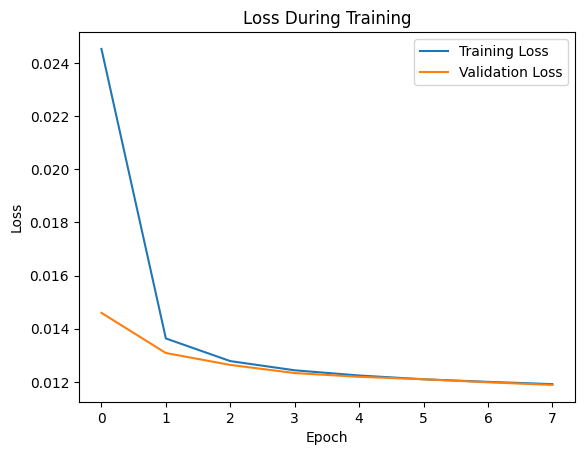

In [80]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.show()

# part III: visualisation

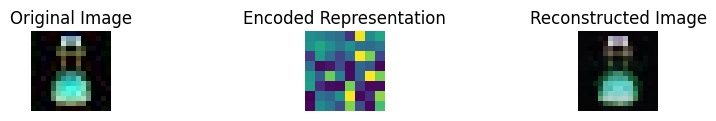

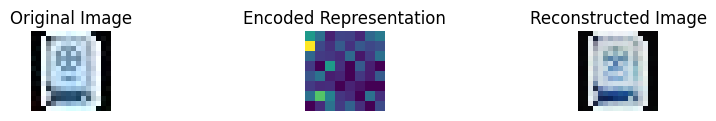

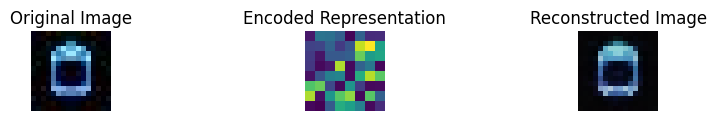

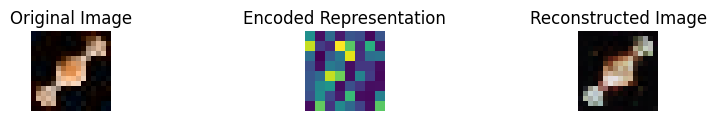

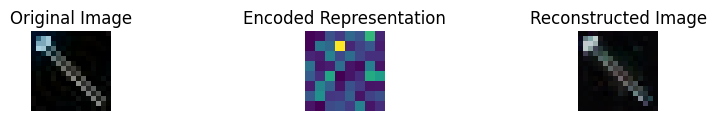

In [85]:
n = 5
for i in range(n):
  random_index = np.random.randint(0, len(x_test))
  original_image = x_test[random_index]

  encoded_image = autoencoder.encoder(np.expand_dims(original_image, axis=0)).numpy()[0]
  decoded_image = autoencoder.decoder(np.expand_dims(encoded_image, axis=0)).numpy()[0]

  plt.figure(figsize=(10, 6))

  plt.subplot(n, 3, i * 3 + 1)
  plt.imshow(original_image)
  plt.title("Original Image")
  plt.axis('off')

  plt.subplot(n, 3, i * 3 + 2)
  plt.imshow(encoded_image.reshape(8,8))
  plt.title("Encoded Representation")
  plt.axis('off')

  plt.subplot(n, 3, i * 3 + 3)
  plt.imshow(np.clip(decoded_image, 0, 1))
  plt.title("Reconstructed Image")
  plt.axis('off')

plt.show()